In [17]:
dstype = 's2d' 
mname = 'debertaV3'

In [18]:
 
modelpath = 'microsoft/deberta-v3-base'
# modelpath = "bert-base-uncased"


datapath = None
saveDIR = f"/home/bhairavi/om/om5/{dstype}/{mname}_{dstype}"
print(saveDIR)
# %%

/home/bhairavi/om/om5/s2d/debertaV3_s2d


In [19]:


# %%
# %%
 
import os
import torch 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

torch.cuda.empty_cache() 

import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
 

 


# %%
 


In [20]:
df = pd.read_csv('/home/bhairavi/om/om4/s2d/Symptom2Disease.csv')



 
 
df.info()
 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1200 non-null   int64 
 1   label       1200 non-null   object
 2   text        1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.2+ KB


In [21]:

# %%

# %%
df.sample(5)


# %%


,Unnamed: 0,label,text
1061,161,drug reaction,In addition to experiencing a change in taste ...
694,94,Hypertension,"When I first experienced a headache, chest pai..."
84,84,Varicose Veins,The cramps in my calves are becoming more freq...
543,243,Arthritis,My neck has been very tight and my muscles hav...
362,62,Common Cold,"I keep sneezing, and I'm miserable and exhaust..."


24

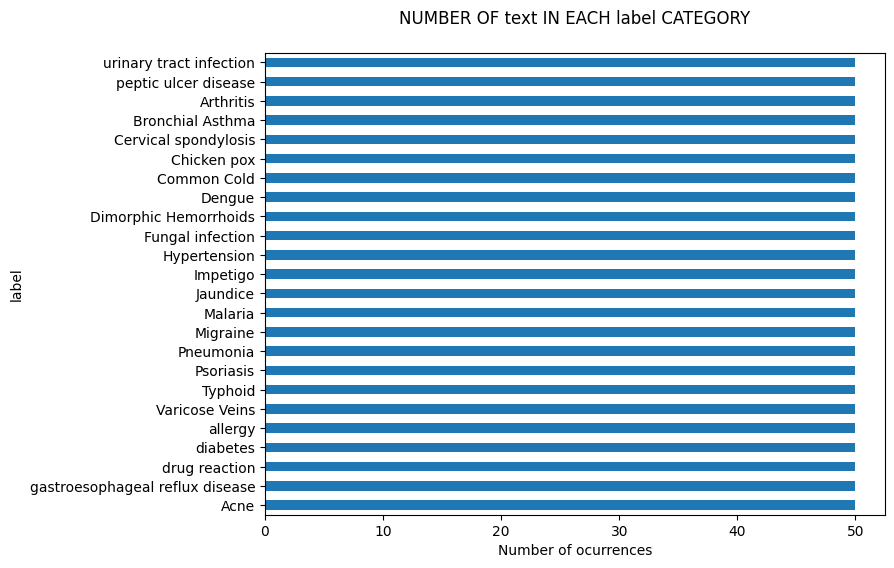

In [22]:


# %%

# %%
from sklearn.preprocessing import LabelEncoder

# %%
le = LabelEncoder()
df['target'] = le.fit_transform(df['label'])

# %%



# %%

# %%
fig = plt.figure(figsize=(8,6)) 
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0,   title= 'NUMBER OF text IN EACH label CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);


# %%


# %%

# %%
numlabel = df['target'].nunique()
numlabel


In [23]:
df.drop(columns=["Unnamed: 0"], inplace=True)


In [24]:
df.columns

Index(['label', 'text', 'target'], dtype='object')

In [25]:
numlabel = df['target'].nunique()
numlabel


24

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda"  # the device to load the model onto

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=numlabel)

# Move the model to the specified device
model.to(device)

/home/bhairavi/om/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/bhairavi/om/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint 

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [27]:
df['token_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Calculate the maximum token length
max_length = df['token_length'].max()

# Calculate the next maximum token length
next_max_token_length = df['token_length'].nlargest(2).iloc[1]

# Calculate the average token length
average_token_length = df['token_length'].mean()

# Display the results
print(f"Maximum token length: {max_length}")
print(f"Next maximum token length: {next_max_token_length}")
print(f"Average token length: {average_token_length:.2f}")

Maximum token length: 75
Next maximum token length: 68
Average token length: 37.68


In [28]:

# %%
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting off the test set with 5% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # 5% for test
for train_val_idx, test_idx in sss.split(df, df['target']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

# Further split train_val_df into train and validation sets with validation set being 15.79% of the remaining data
# (which is equivalent to 15% of the original dataset size)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)  # ~15.79% of remaining data
for train_idx, val_idx in sss_val.split(train_val_df, train_val_df['target']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
 

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs['label'] = list(map(int, examples['target']))
    return tokenized_inputs

# Convert pandas DataFrame to Hugging Face's Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df) 
test_dataset = Dataset.from_pandas(test_df)

# Map the tokenization function across the datasets
train_dataset = train_dataset.map(tokenize_and_format, batched=True,batch_size=16)
eval_dataset = eval_dataset.map(tokenize_and_format, batched=True,batch_size=16) 
test_dataset = test_dataset.map(tokenize_and_format, batched=True,batch_size=16)




Map: 100%|██████████| 60/60 [00:00<00:00, 4602.97 examples/s]


In [33]:


# %%
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall,
    }

 


# %%

# %%
 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Use 'epoch' to evaluate at the end of each epoch
    save_strategy="epoch",  # Also use 'epoch' to save at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Load the best model at the end of training based on metric
    metric_for_best_model='f1',  # Define the metric for evaluating the best model
    logging_dir='./logs',
    logging_steps=10,
    report_to=[] 
)


 

trainer = Trainer(
    model=model,
    args=training_args ,  # Here you will need to make sure that the Trainer is set up correctly
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Start training
trainer.train()

 
 



/home/bhairavi/om/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.157700,0.262112,0.921836,0.939717,0.923977


KeyboardInterrupt: 

In [34]:
# save_directory = saveDIR
 

# # Save the model
# model.save_pretrained(save_directory)

# # Save the tokenizer (optional, but recommended)
# tokenizer.save_pretrained(save_directory)

('/home/bhairavi/om/om5/s2d/debertaV3_s2d/tokenizer_config.json',
 '/home/bhairavi/om/om5/s2d/debertaV3_s2d/special_tokens_map.json',
 '/home/bhairavi/om/om5/s2d/debertaV3_s2d/spm.model',
 '/home/bhairavi/om/om5/s2d/debertaV3_s2d/added_tokens.json',
 '/home/bhairavi/om/om5/s2d/debertaV3_s2d/tokenizer.json')

In [35]:

# %%
from colorama import Fore, Style


# %% [markdown]
# eval dataset performance so that keywords_classes can be fixed

# %%
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(eval_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)
print(Fore.CYAN,"keywords class evaluation detection RESULTS")
print(report)


# %% [markdown]
# skyline

# %%


 keywords class evaluation detection RESULTS
                                 precision    recall  f1-score   support

                      Psoriasis     1.0000    1.0000    1.0000         7
                 Varicose Veins     1.0000    1.0000    1.0000         7
                        Typhoid     1.0000    0.8750    0.9333         8
                    Chicken pox     1.0000    1.0000    1.0000         7
                       Impetigo     0.8750    1.0000    0.9333         7
                         Dengue     0.7000    1.0000    0.8235         7
               Fungal infection     1.0000    0.7143    0.8333         7
                    Common Cold     1.0000    1.0000    1.0000         7
                      Pneumonia     1.0000    1.0000    1.0000         7
          Dimorphic Hemorrhoids     0.8750    1.0000    0.9333         7
                      Arthritis     1.0000    1.0000    1.0000         7
                           Acne     1.0000    1.0000    1.0000         7
     

In [36]:


# %%
print(Fore.RED +"TEST DATA IS OUR SKYLINE RESULT")
 
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)

print(report)


TEST DATA IS OUR SKYLINE RESULT
                                 precision    recall  f1-score   support

                      Psoriasis     1.0000    1.0000    1.0000         2
                 Varicose Veins     1.0000    1.0000    1.0000         2
                        Typhoid     1.0000    1.0000    1.0000         2
                    Chicken pox     1.0000    1.0000    1.0000         3
                       Impetigo     1.0000    1.0000    1.0000         3
                         Dengue     1.0000    1.0000    1.0000         2
               Fungal infection     1.0000    1.0000    1.0000         3
                    Common Cold     1.0000    1.0000    1.0000         3
                      Pneumonia     1.0000    1.0000    1.0000         2
          Dimorphic Hemorrhoids     1.0000    1.0000    1.0000         2
                      Arthritis     1.0000    1.0000    1.0000         3
                           Acne     1.0000    1.0000    1.0000         2
               Bro